In [86]:
#instalação de pacotes
#!pip3 install pyramid-arima
!pip install pmdarima
!pip install mysql-connector-python
!pip install keras
!pip install tensorflow

You should consider upgrading via the '/home/rafael/Apps/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rafael/Apps/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rafael/Apps/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rafael/Apps/anaconda3/bin/python -m pip install --upgrade pip' command.


In [87]:
#from statsmodels.tsa.stattools import adfuller
#from numpy import log
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Importa dados

In [1]:

import numpy as np
import pandas as pd
import mysql.connector

#Conecta com banco MySQL
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='projeto',
                                         user='root',
                                         password='12345678')

    produto_proc = "5797"
    
    sql_select_Query = " select ds_data_sem_hora \
                        ,isbn_produto \
                        ,qtd_venda  \
                        from fato_venda as ft \
                        , dim_tempo as tp \
                        , dim_produto as pd \
                        where tp.sk_tempo = ft.sk_tempo \
                        and pd.sk_produto = ft.sk_protudo \
                        and pd.sk_produto = " + produto_proc 
    
    cursor = connection.cursor()
    cursor.execute(sql_select_Query)
    
    #carrega dados
    records = cursor.fetchall()

    data_sql = pd.DataFrame(records)

except mysql.connector.Error as e:
    print("Error reading data from MySQL table", e)
finally:
    if connection.is_connected():
        connection.close()
        cursor.close()
        print("MySQL connection is closed")
        
data_sql.info()

MySQL connection is closed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       25 non-null     object
 1   1       25 non-null     object
 2   2       25 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 728.0+ bytes


In [2]:
#ajusta dados para a predição
df = data_sql.copy()

#adiciona nome nas colunas
df = df.rename(columns={0: "date",1:"isbn", 2: "value"})

#transforma para datetime
df["date"] = pd.to_datetime(df["date"])

#ordena
df = df.sort_values('date')

#soma quantidade em datas iguais
df = df.groupby('date')['value'].sum().reset_index()

#transforma a data em indice
df = df.set_index('date')

#agrupa na soma do mês
df = df['value'].resample('MS').sum()

# Analisa os dados

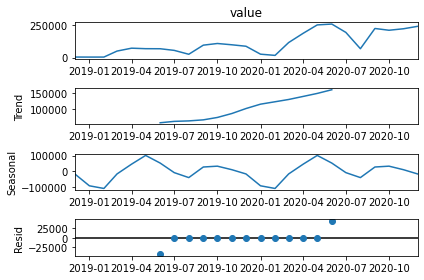

In [3]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt

a = seasonal_decompose(df, model = "add")
a.plot();

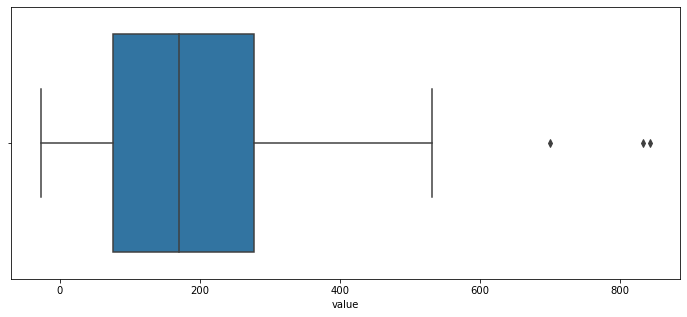

In [803]:
#Boxplot
import seaborn

fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(df, ax=ax)

Ajuste dados

In [4]:
df.describe()

count        25.000000
mean     110249.000000
std       86220.563262
min        3790.000000
25%       50078.000000
50%       87276.000000
75%      193843.000000
max      258209.000000
Name: value, dtype: float64

In [5]:
df.where(df<df.quantile(0.95))

date
2018-12-01      4052.0
2019-01-01      3790.0
2019-02-01      3891.0
2019-03-01     50078.0
2019-04-01     72357.0
2019-05-01     68485.0
2019-06-01     68013.0
2019-07-01     55380.0
2019-08-01     25507.0
2019-09-01     95625.0
2019-10-01    108462.0
2019-11-01     98431.0
2019-12-01     87276.0
2020-01-01     26149.0
2020-02-01     16878.0
2020-03-01    115674.0
2020-04-01    187070.0
2020-05-01         NaN
2020-06-01         NaN
2020-07-01    193843.0
2020-08-01     68274.0
2020-09-01    224094.0
2020-10-01    210482.0
2020-11-01    222018.0
2020-12-01    240590.0
Freq: MS, Name: value, dtype: float64

In [6]:
df.where(((df-df.mean()).abs() < 3*df.std()))

date
2018-12-01      4052
2019-01-01      3790
2019-02-01      3891
2019-03-01     50078
2019-04-01     72357
2019-05-01     68485
2019-06-01     68013
2019-07-01     55380
2019-08-01     25507
2019-09-01     95625
2019-10-01    108462
2019-11-01     98431
2019-12-01     87276
2020-01-01     26149
2020-02-01     16878
2020-03-01    115674
2020-04-01    187070
2020-05-01    251597
2020-06-01    258209
2020-07-01    193843
2020-08-01     68274
2020-09-01    224094
2020-10-01    210482
2020-11-01    222018
2020-12-01    240590
Freq: MS, Name: value, dtype: int64

In [7]:
#Trata outliers superiores 

#df = df.where(((df-df.mean()).abs() < 3*df.std()),3*df.std())
df = df.where(df<df.quantile(0.95),df.quantile(0.95))

#Copia para dataframe dos demais modelos
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

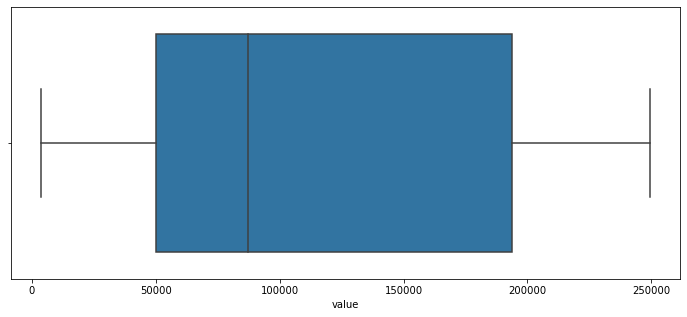

In [8]:
#Boxplot
import seaborn

fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(df1, ax=ax)

In [9]:
#Separa dados
train = df1.iloc[:len(df1)-12]
test = df1.iloc[len(df1)-12:]

#Períodos de predição
n_periods = 24

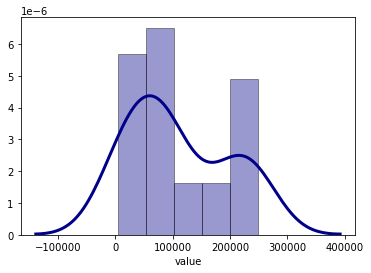

In [10]:
#Histograma
seaborn.distplot(df1, hist=True, kde=True, 
             bins=5, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3});

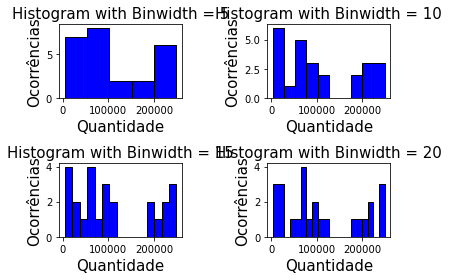

In [11]:
for i, binwidth in enumerate([5, 10, 15, 20]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df1, bins = binwidth, color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 15)
    ax.set_xlabel('Quantidade', size = 15)
    ax.set_ylabel('Ocorrências', size= 15)

plt.tight_layout()
plt.show()

# Modelos

Modelo Auto ARIMA

In [15]:
import pmdarima as pm

#Fit modelo auto-arima
fitSArima = pm.auto_arima(df1, start_p=1, start_q=1,
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

#test='adf',

#fitSArima = pm.auto_arima(df1, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4) 

fitSArima.fit(train)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [16]:
#Teste 1
pm.auto_arima(df1, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
              d=None, D=1, trace=False,error_action='ignore',suppress_warnings=True,stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   25
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -155.383
Date:                            Sun, 13 Jun 2021   AIC                            318.767
Time:                                    18:13:34   BIC                            321.027
Sample:                                         0   HQIC                           318.302
                                             - 25                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.192e+05    3.9e+04      3.059      0.002    4.28e+04    1.96e+05
ma.L1          0.5448      0.324      1.681      0.093      -0.091       1.180
ma.S.L12       0.7025      0.874      0.804      0.422      -1.011       2.416
sigma2      1.437e+09      0.675   2.13e+09      0.000    1.44e+09    1.44e+09
===================================================================================
Ljung-Box (Q):                        8.49   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.75   Prob(JB):                         0.77
Heteroskedasticity (H):               1.22   Skew:                            -0.06
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.63e+25. Standard errors may be unstable.
"""

In [814]:
#Teste 2
#pm.auto_arima(df1, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

In [17]:
#Forecast auto-arima
index_pred = pd.date_range(test.index[0], periods = n_periods, freq='MS')

predSArima, confint = fitSArima.predict(n_periods=n_periods, return_conf_int=True)

#Cria dataseries
predSArima = pd.DataFrame(predSArima,index = index_pred,columns=['SARIMA'])

Modelo Prophet

In [816]:
#Dados Prophet
#df2 = data_sql

#adiciona nome nas colunas
#df2 = df2.rename(columns={0: "ds",1:"isbn", 2: "y"})

#transforma para datetime
#df2["ds"] = pd.to_datetime(df2["ds"])

#df2['ds'] = df2['ds'].values.astype('datetime64[M]')

#df2 = df2.groupby(['ds']).sum()

#df2 = df2.reset_index()

#df2.info()

In [19]:
#Dados Prophet
df2 = df.to_frame()

#Reinicia indice
df2 = df2.reset_index()

#adiciona nome nas colunas
df2 = df2.rename(columns={"date":"ds","value":"y"})

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      25 non-null     datetime64[ns]
 1   y       25 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 528.0 bytes


In [20]:
from fbprophet import Prophet

#Fit modelo Prophet
fitProphet = Prophet()

fitProphet.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


In [21]:
#Forecast Prophet
future = fitProphet.make_future_dataframe(periods=12, freq='MS')

predProphetfull = fitProphet.predict(future)

predProphet = predProphetfull[['ds','yhat']]

predProphet = predProphet.set_index('ds')
predProphet = predProphet.rename(columns={"yhat": "PROPHET"})

predProphet = predProphet.iloc[-24:]

Modelo LSTM

In [820]:
#Dados LSTM

#importa dados
#df3 = data_sql

#adiciona nome nas colunas
#df3 = df3.rename(columns={0: "ds",1:"isbn", 2: "Venda"})

#transforma para datetime
#df3["Mes"] = pd.to_datetime(df3["ds"])

#df3['Mes'] = df3['Mes'].values.astype('datetime64[M]')

#df3.drop(['ds','isbn'], axis=1, inplace=True)

#df3 = df3.groupby(['Mes']).sum()

#df3 = df3.reset_index()

#df3 = df3.set_index("Mes")

#df3.index.freq = 'MS'

#train_data = df3[:len(df3)-12]
#test_data = df3[len(df3)-12:]

In [22]:
#Dados LSTM

#Copia dos dados tratados
df3 = df.to_frame()

#Cria data frame train e teste
train_data = df3[:len(df3)-12]
test_data = df3[len(df3)-12:]

df3.head()

,value
date,
2018-12-01,4052.0
2019-01-01,3790.0
2019-02-01,3891.0
2019-03-01,50078.0
2019-04-01,72357.0


In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [24]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [25]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = n_periods
#n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=2)

ValueError: `start_index+length=24 > end_index=12` is disallowed, as no part of the sequence would be left to be used as current step.

In [825]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [826]:
nepochs=50
lstm_model.fit_generator(generator,epochs=nepochs)

Epoch 1/50


/home/rafael/Apps/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12/12 [==============================] - 1s 32ms/step - loss: 0.2370
Epoch 2/50
12/12 [==============================] - 1s 41ms/step - loss: 0.0878
Epoch 3/50
12/12 [==============================] - 0s 37ms/step - loss: 0.0675
Epoch 4/50
12/12 [==============================] - 1s 47ms/step - loss: 0.0582
Epoch 5/50
12/12 [==============================] - 0s 31ms/step - loss: 0.0750
Epoch 6/50
12/12 [==============================] - 0s 36ms/step - loss: 0.1099
Epoch 7/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0984
Epoch 8/50
12/12 [==============================] - 0s 34ms/step - loss: 0.0652
Epoch 9/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0676
Epoch 10/50
12/12 [==============================] - 0s 32ms/step - loss: 0.0518
Epoch 11/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0780
Epoch 12/50
12/12 [==============================] - 0s 37ms/step - loss: 0.1100
Epoch 13/50
12/12 [=============================

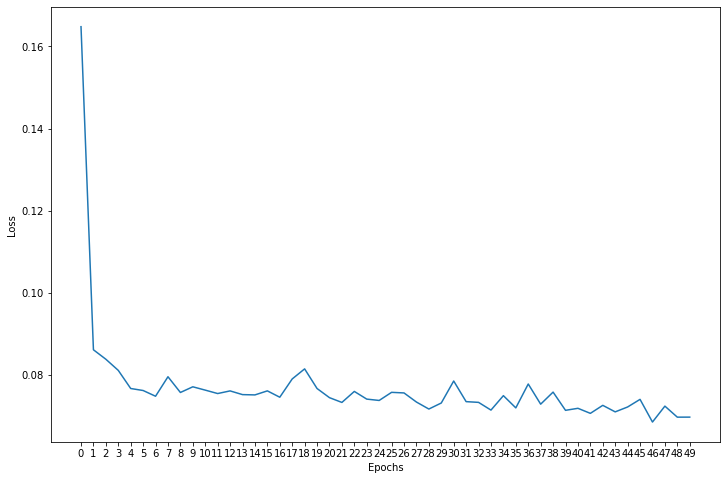

In [827]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,8))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,nepochs,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [828]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(n_input):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [829]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Avaliação do Forecast

In [830]:
#Concatena predições
forecast = pd.concat([test,predSArima,predProphet],axis=1)
forecast['LSTM'] = lstm_predictions

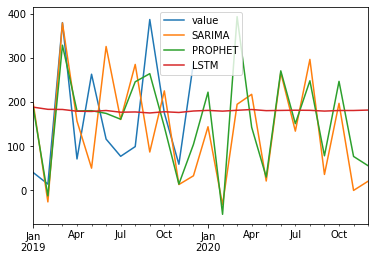

In [831]:
forecast.plot()

In [832]:
forecast['Ac_venda'] = test.cumsum()
forecast['Ac_SArima'] = forecast['SARIMA'].cumsum()
forecast['Ac_PROPHET'] = forecast['PROPHET'].cumsum()
forecast['Ac_LSTM'] = forecast['LSTM'].cumsum()

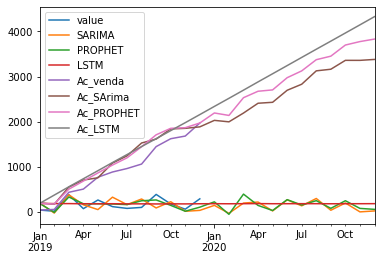

In [833]:
forecast.plot()

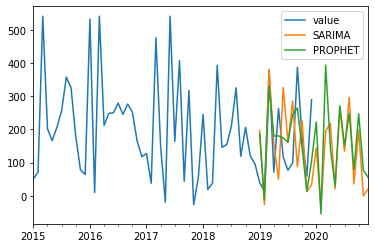

In [834]:
#Visão geral
pd.concat([df1,predSArima,predProphet],axis=1).plot()

Exporta Dados

In [835]:
#forecast.to_excel ('forecast.xlsx', index = True, header=True, sheet_name = 'Dados')

In [836]:
df_export = forecast.copy()
df_export["sk_tempo"] = df_export.index.strftime('%Y%m%d').astype(int)
df_export["sk_protudo"] = int(produto_proc)

df_export = df_export.rename(columns={"value":"qtd_venda","Ac_venda":"acm_venda"})
df_export = df_export.rename(columns={"PROPHET":"qtd_prophet","Ac_PROPHET":"acm_prophet"})
df_export = df_export.rename(columns={"LSTM":"qtd_lstm","Ac_LSTM":"acm_lstm"})
df_export = df_export.rename(columns={"SARIMA":"qtd_sarima","Ac_SArima":"acm_sarima"})
df_export = df_export.replace(np.nan,0)

df_export.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2019-01-01 to 2020-12-01
Freq: MS
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   qtd_venda    24 non-null     float64
 1   qtd_sarima   24 non-null     float64
 2   qtd_prophet  24 non-null     float64
 3   qtd_lstm     24 non-null     float64
 4   acm_venda    24 non-null     float64
 5   acm_sarima   24 non-null     float64
 6   acm_prophet  24 non-null     float64
 7   acm_lstm     24 non-null     float64
 8   sk_tempo     24 non-null     int64  
 9   sk_protudo   24 non-null     int64  
dtypes: float64(8), int64(2)
memory usage: 2.1 KB


In [837]:
#df1 = df1.rename(columns={0: "date",1:"isbn", 2: "value"})
df_export

,qtd_venda,qtd_sarima,qtd_prophet,qtd_lstm,acm_venda,acm_sarima,acm_prophet,acm_lstm,sk_tempo,sk_protudo
2019-01-01,40.0,195.859519,186.747988,188.395991,40.0,195.859519,186.747988,188.395991,20190101,12804
2019-02-01,14.0,-26.330954,-12.650818,183.472878,54.0,169.528565,174.097169,371.868869,20190201,12804
2019-03-01,380.0,379.249149,328.816525,183.154652,434.0,548.777714,502.913694,555.023520,20190301,12804
2019-04-01,71.0,156.759695,179.859908,179.194655,505.0,705.537410,682.773602,734.218175,20190401,12804
2019-05-01,263.0,50.120002,180.404164,178.673477,768.0,755.657411,863.177766,912.891652,20190501,12804
2019-06-01,116.0,325.850117,174.249645,180.831443,884.0,1081.507529,1037.427411,1093.723095,20190601,12804
2019-07-01,77.0,160.461706,160.978032,176.925896,961.0,1241.969234,1198.405443,1270.648991,20190701,12804
2019-08-01,99.0,285.234103,245.921244,177.499833,1060.0,1527.203337,1444.326687,1448.148824,20190801,12804
2019-09-01,387.0,86.741735,264.335062,175.237110,1447.0,1613.945072,1708.661749,1623.385934,20190901,12804
2019-10-01,175.0,225.269617,143.864405,178.010341,1622.0,1839.214690,1852.526154,1801.396275,20191001,12804


In [838]:
#Grava dados no MySQL
try:
    # Connect to the database
    connection = mysql.connector.connect(host='localhost',
                                         database='projeto',
                                         user='root',
                                         password='12345678')

    cursor = connection.cursor()

    # Create a new record
    query = " DELETE FROM projeto.fato_predicao WHERE sk_protudo = " + produto_proc

    cursor.execute(query)

    # connection is not autocommit by default. So we must commit to save our changes.
    connection.commit()

    # Create a new record
    #query = """INSERT INTO projeto.fato_predicao (sk_tempo, sk_protudo, qtd_predicao, qtd_acumula) VALUES(%s, %s, %s, %s) ON DUPLICATE KEY UPDATE qtd_predicao=%s, qtd_acumula=%s"""
    #cursor.execute(query, (df_export.sk_tempo[i], df_export.sk_protudo[i], df_export.PROPHET[i], df_export.Ac_PROPHET[i], df_export.PROPHET[i], df_export.Ac_PROPHET[i]))

    query = """INSERT INTO projeto.fato_predicao (sk_tempo, sk_protudo, no_modelo, qtd_predicao, qtd_acumula) VALUES(%s, %s, %s, %s, %s) ON DUPLICATE KEY UPDATE qtd_predicao=%s, qtd_acumula=%s"""
    
    for index, row in df_export.iterrows():
        #Grava dados da Venda Realizada
        cModelo = 'Venda'
        nQtdInsert = row['qtd_venda'].item() 
        nAcmInsert = row['acm_venda'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

        #Grava dados PROPHET
        cModelo = 'Prophet'
        nQtdInsert = row['qtd_prophet'].item() 
        nAcmInsert = row['acm_prophet'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

        #Grava dados SArima        
        cModelo = 'SArima'
        nQtdInsert = row['qtd_sarima'].item() 
        nAcmInsert = row['acm_sarima'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

        #Grava dados LSTM        
        cModelo = 'LSTM'
        nQtdInsert = row['qtd_lstm'].item() 
        nAcmInsert = row['acm_lstm'].item()
        
        cursor.execute(query, (row['sk_tempo'].item(), row['sk_protudo'].item(), cModelo, nQtdInsert, nAcmInsert, nQtdInsert, nAcmInsert))       

    # connection is not autocommit by default. So we must commit to save our changes.
    connection.commit()

    # Execute query
    sql = "SELECT * FROM projeto.fato_predicao WHERE sk_protudo = " + produto_proc 
    
    cursor.execute(sql)
    
    # Fetch all the records
    result = cursor.fetchall()
    
    for i in result:
        print(i)

finally:
    # close the database connection using close() method.
    connection.close()

(20190101, 12804, 'LSTM', Decimal('188.40'), Decimal('188.40'))
(20190101, 12804, 'Prophet', Decimal('186.75'), Decimal('186.75'))
(20190101, 12804, 'SArima', Decimal('195.86'), Decimal('195.86'))
(20190101, 12804, 'Venda', Decimal('40.00'), Decimal('40.00'))
(20190201, 12804, 'LSTM', Decimal('183.47'), Decimal('371.87'))
(20190201, 12804, 'Prophet', Decimal('-12.65'), Decimal('174.10'))
(20190201, 12804, 'SArima', Decimal('-26.33'), Decimal('169.53'))
(20190201, 12804, 'Venda', Decimal('14.00'), Decimal('54.00'))
(20190301, 12804, 'LSTM', Decimal('183.15'), Decimal('555.02'))
(20190301, 12804, 'Prophet', Decimal('328.82'), Decimal('502.91'))
(20190301, 12804, 'SArima', Decimal('379.25'), Decimal('548.78'))
(20190301, 12804, 'Venda', Decimal('380.00'), Decimal('434.00'))
(20190401, 12804, 'LSTM', Decimal('179.19'), Decimal('734.22'))
(20190401, 12804, 'Prophet', Decimal('179.86'), Decimal('682.77'))
(20190401, 12804, 'SArima', Decimal('156.76'), Decimal('705.54'))
(20190401, 12804, 'Ve